In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

plt.style.use("plot_style.txt")

In [2]:
df_vaksin_full = pd.read_excel("dataset/dataset_kawal.xlsx", sheet_name="vaksin", index_col="date")
df_vaksin_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220 entries, 2021-01-13 to 2021-08-20
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vaksin1  220 non-null    int64  
 1   vaksin2  206 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.2 KB


In [3]:
df_vaksin = df_vaksin_full[["vaksin2"]].dropna()
df_vaksin.head()

,vaksin2
date,
2021-01-27,66.0
2021-01-28,5468.0
2021-01-29,11287.0
2021-01-30,20810.0
2021-01-31,22548.0


In [4]:
# Fungsi untuk uji stasioner time series
def test_stationarity(timeseries, roll=5):
    rolmean = timeseries.rolling(roll).mean()
    rolstd = timeseries.rolling(roll).std()

    fig, ax = plt.subplots()
    ax.plot(timeseries, color='blue', label='Original')
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    ax.set_title("Rolling Mean & Standard Deviation")
    ax.set_xlabel("Tanggal")
    ax.set_ylabel("Jumlah Kasus")
    plt.show()

    print('>> Dickey-Fuller Test <<')
    dftest = sm.tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value

    print(dfoutput)

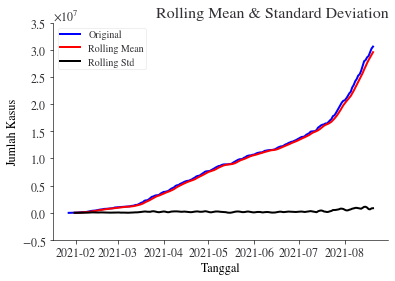

>> Dickey-Fuller Test <<
Test Statistic                   1.175305
p-value                          0.995811
#Lags Used                      15.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


In [5]:
# Uji stasioner data mentah
test_stationarity(df_vaksin)

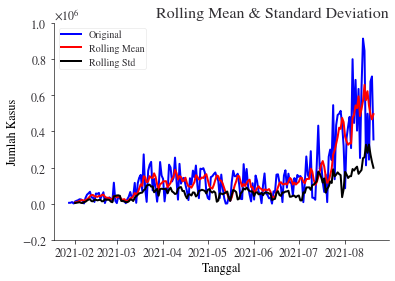

>> Dickey-Fuller Test <<
Test Statistic                   1.714890
p-value                          0.998164
#Lags Used                      14.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


In [6]:
df_vaksin2_diff = df_vaksin - df_vaksin.shift()
df_vaksin2_diff.dropna(inplace=True)
test_stationarity(df_vaksin2_diff)

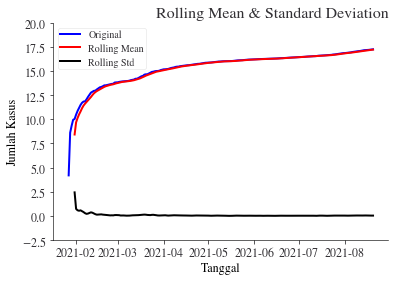

>> Dickey-Fuller Test <<
Test Statistic                  -2.167337
p-value                          0.218313
#Lags Used                      13.000000
Number of Observations Used    192.000000
Critical Value (1%)             -3.464875
Critical Value (5%)             -2.876714
Critical Value (10%)            -2.574859
dtype: float64


In [7]:
df_vaksin2_log = df_vaksin.apply(np.log)
df_vaksin2_log.dropna(inplace=True)
test_stationarity(df_vaksin2_log)

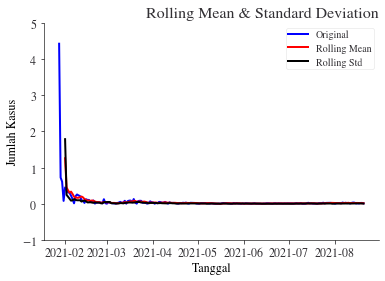

>> Dickey-Fuller Test <<
Test Statistic                  -5.518530
p-value                          0.000002
#Lags Used                      12.000000
Number of Observations Used    192.000000
Critical Value (1%)             -3.464875
Critical Value (5%)             -2.876714
Critical Value (10%)            -2.574859
dtype: float64


In [8]:
df_vaksin2_log_diff = df_vaksin2_log - df_vaksin2_log.shift()
df_vaksin2_log_diff.dropna(inplace=True)
test_stationarity(df_vaksin2_log_diff)

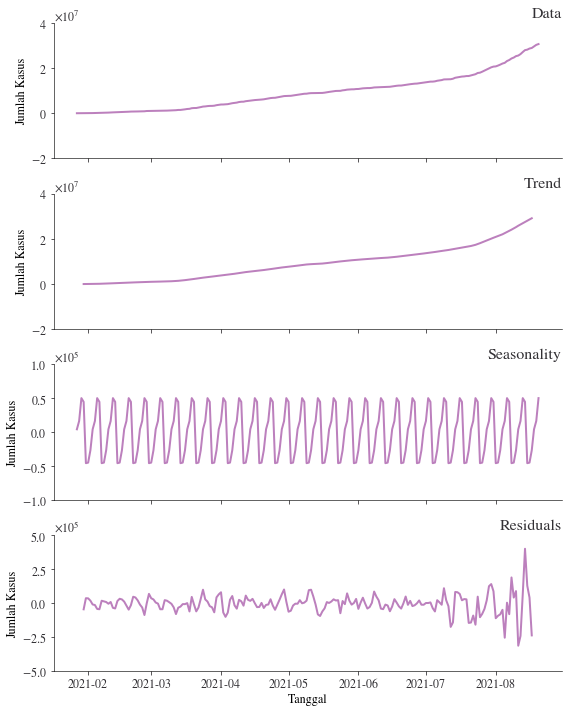

In [23]:
# Dekomposisi komponen musiman
decomposition = sm.tsa.seasonal_decompose(df_vaksin)

plt.figure(figsize=(8,10))
ax1 = plt.subplot(4, 1, 1)
ax1.plot(df_vaksin)
ax1.set_title("Data")
ax1.set_ylabel("Jumlah Kasus")
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(4, 1, 2, sharex=ax1)
ax2.plot(decomposition.trend)
ax2.set_title("Trend")
ax2.set_ylabel("Jumlah Kasus")
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(4, 1, 3, sharex=ax1)
ax3.plot(decomposition.seasonal)
ax3.set_title("Seasonality")
ax3.set_ylabel("Jumlah Kasus")
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(4, 1, 4, sharex=ax1)
plt.plot(decomposition.resid)
ax4.set_title("Residuals")
ax4.set_xlabel("Tanggal")
ax4.set_ylabel("Jumlah Kasus")

plt.tight_layout()

<ipython-input-26-7fe2ac65e933>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


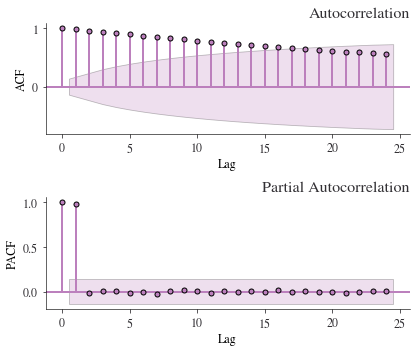

In [26]:
# Plot ACF dan PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

sm.graphics.tsa.plot_acf(df_vaksin, ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

sm.graphics.tsa.plot_pacf(df_vaksin, ax=ax2)
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

fig.tight_layout()
fig.show()

E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='date'>

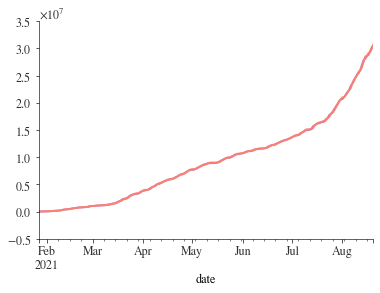

In [11]:
model_base = sm.tsa.ETSModel(df_vaksin["vaksin2"], initialization_method="heuristic", trend="add", error="add", seasonal=None, damped_trend=False)
model = model_base.fit(maxiter=10000)

df_vaksin["vaksin2"].plot(label="data")
model.fittedvalues.plot(label="statsmodels fit")

In [12]:
print(model.summary())

                                 ETS Results                                  
Dep. Variable:                vaksin2   No. Observations:                  206
Model:                       ETS(AAN)   Log Likelihood               -2673.491
Date:                Sun, 22 Aug 2021   AIC                           5352.981
Time:                        13:22:12   BIC                           5362.965
Sample:                    01-27-2021   HQIC                          5357.019
                         - 08-20-2021   Scale                  10969048119.625
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.063     15.915      0.000       0.877       1.123
smoothing_trend     0.1969      0.037      5.346      0.000       0.125       0.269
              initialization met

In [13]:
df_vaksin.head()

,vaksin2
date,
2021-01-27,66.0
2021-01-28,5468.0
2021-01-29,11287.0
2021-01-30,20810.0
2021-01-31,22548.0


In [14]:
# Melakukan prediksi data 6 bulan terakhir
y_true = df_vaksin["2021-02-01":"2021-08-01"]["vaksin2"]
y_pred = model.predict(start="2021-02-01", end="2021-08-01")

print("RMSE: {0:,.2f}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
print("MAE: {0:,.2f}".format(mean_absolute_error(y_true, y_pred)))
print("MAPE: {0:.2%}".format(mean_absolute_percentage_error(y_true, y_pred)))

RMSE: 82,138.46
MAE: 59,578.32
MAPE: 1.79%


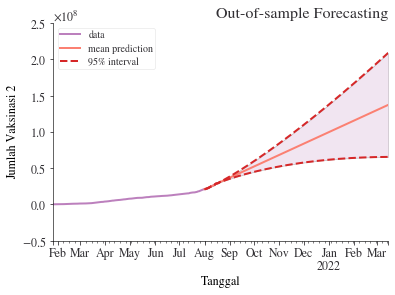

In [28]:
# daily end: 2022-03-15
# monthly end: 
pred = model.get_prediction(start="2021-08-01", end="2022-03-15")
pred_summary_df = pred.summary_frame(alpha=0.05)

fig, ax = plt.subplots()

df_vaksin["vaksin2"].plot(label="data", ax=ax)
pred_summary_df["mean"].plot(label="mean prediction", ax=ax)
pred_summary_df["pi_lower"].plot(linestyle="--", color="tab:red", label="95% interval", ax=ax)
pred_summary_df["pi_upper"].plot(linestyle="--", color="tab:red", label="_", ax=ax)
ax.fill_between(pred_summary_df.index, pred_summary_df["pi_lower"], pred_summary_df["pi_upper"], alpha=0.2)

plt.legend()
plt.title("Out-of-sample Forecasting")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Jumlah Vaksinasi 2")
plt.show()

In [16]:
pred_summary_df.tail(10).style.format(formatter={
    "mean": "{:,.2f}",
    "pi_lower": "{:,.2f}",
    "pi_upper": "{:,.2f}"
})

,mean,pi_lower,pi_upper
2022-03-06 00:00:00,"132,539,306.03","65,259,421.84","199,819,190.23"
2022-03-07 00:00:00,"133,054,224.26","65,275,541.51","200,832,907.00"
2022-03-08 00:00:00,"133,569,142.48","65,290,434.64","201,847,850.32"
2022-03-09 00:00:00,"134,084,060.70","65,304,104.23","202,864,017.17"
2022-03-10 00:00:00,"134,598,978.92","65,316,553.26","203,881,404.58"
2022-03-11 00:00:00,"135,113,897.15","65,327,784.69","204,900,009.60"
2022-03-12 00:00:00,"135,628,815.37","65,337,801.45","205,919,829.29"
2022-03-13 00:00:00,"136,143,733.59","65,346,606.46","206,940,860.72"
2022-03-14 00:00:00,"136,658,651.82","65,354,202.62","207,963,101.02"
2022-03-15 00:00:00,"137,173,570.04","65,360,592.78","208,986,547.30"
